<a href="https://colab.research.google.com/github/realfolkcode/AdversarialRegularization/blob/main/filters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
!git clone https://github.com/realfolkcode/AdversarialRegularization.git

Cloning into 'AdversarialRegularization'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 41 (delta 15), reused 17 (delta 4), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [3]:
from AdversarialRegularization.utils import set_random_seeds

# Loading Models

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.features(x)
        x = self.classifier(x)
        return x

We want to collect good filters. For that purpose, we load models that have been trained on a large dataset. These models differ only in initial weight initialization.

In [5]:
model_dir = 'AdversarialRegularization/models/'
model_lst = []

for model_name in os.listdir('AdversarialRegularization/models/'):
    model_path = os.path.join(model_dir, model_name)
    model = CNN(num_classes=100)
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    model_lst.append(model)

In [6]:
model_lst[0]

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [7]:
print('Number of models:', len(model_lst))

Number of models: 3


# Filter Dataset

Let us create a class for filters dataset to make life easier. We will use it to train discriminators. As input, it would take a list of convolution layers (kernel sizes must be the same).

In [8]:
class FilterDataset(Dataset):
    def __init__(self, layer_lst):
        self.kernels = [layer.weight.data.clone() for layer in layer_lst]
        self.kernels = torch.cat(self.kernels)
        c_out, c_in, h, w = self.kernels.shape
        self.kernels = self.kernels.view(c_out * c_in, -1, h, w)
    
    def __len__(self):
        return len(self.kernels)
    
    def __getitem__(self, idx):
        return self.kernels[idx]

In [9]:
model_lst[0].features[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [10]:
RANDOM_SEED = 0
set_random_seeds(seed_value=RANDOM_SEED, device=device)

In [11]:
filters_data = []
filters_loader = []

# Create datasets for 7x7, 5x5, 5x5 kernels from corresponding convolution layers 
filters_data.append(FilterDataset([model.features[0] for model in model_lst]))
filters_data.append(FilterDataset([model_lst[0].features[3]]))
filters_data.append(FilterDataset([model_lst[0].features[6]]))

# Create dataloaders for filters datasets
for i in range(len(filters_data)):
    filters_loader.append(DataLoader(filters_data[i], batch_size=32, shuffle=True))

In [12]:
for i in range(len(filters_loader)):
    print(f'Filter Dataset {i} size: {len(filters_loader[i].dataset)}')

Filter Dataset 0 size: 576
Filter Dataset 1 size: 8192
Filter Dataset 2 size: 16384


Now, we can iterate over filters dataset.

In [13]:
for batch in filters_loader[0]:
    print(batch)
    break

tensor([[[[ 0.0310,  0.0786,  0.0807,  ..., -0.0409,  0.0343, -0.0527],
          [ 0.0884,  0.0508, -0.1482,  ...,  0.0682, -0.0750,  0.0354],
          [-0.0207, -0.2354, -0.1533,  ...,  0.1396,  0.0747,  0.0257],
          ...,
          [-0.0396,  0.1509,  0.3189,  ..., -0.2305, -0.1155, -0.0246],
          [ 0.0824,  0.1110, -0.0192,  ..., -0.1338, -0.0108,  0.1167],
          [-0.0386, -0.0329, -0.1152,  ...,  0.1159,  0.1210, -0.0037]]],


        [[[-0.0595, -0.0003,  0.0029,  ...,  0.0292, -0.1154,  0.0148],
          [ 0.0812, -0.0019, -0.0890,  ..., -0.0564,  0.2386,  0.1367],
          [ 0.0049, -0.0212,  0.2077,  ..., -0.2463, -0.0751,  0.1012],
          ...,
          [-0.0928, -0.0724, -0.0339,  ...,  0.0937,  0.0996,  0.0656],
          [ 0.0315, -0.0428,  0.1124,  ..., -0.1575, -0.0373, -0.0284],
          [ 0.0319,  0.0554, -0.1036,  ...,  0.0750, -0.0308, -0.0317]]],


        [[[ 0.1383,  0.1474,  0.0686,  ..., -0.1320, -0.1571, -0.1647],
          [ 0.2295,  0.257

We can also visualize kernels to check if our dataset contains patterns.

In [14]:
def plot_kernels(loader, nrow=8):
    dataiter = iter(loader)
    batch = dataiter.next()
    rows = np.min((batch.shape[0] // nrow + 1, 64))    
    grid = torchvision.utils.make_grid(batch, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

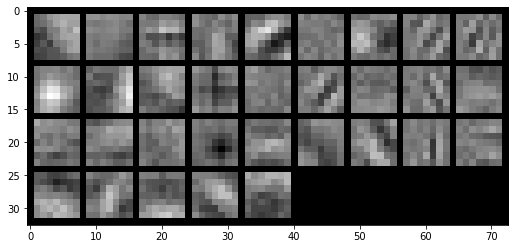

In [15]:
plot_kernels(filters_loader[0], nrow=9)

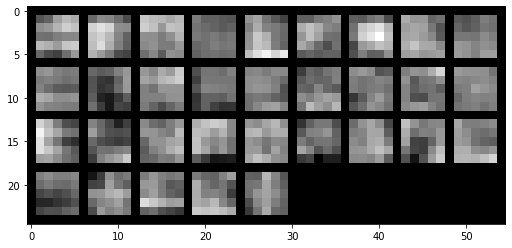

In [16]:
plot_kernels(filters_loader[1], nrow=9)

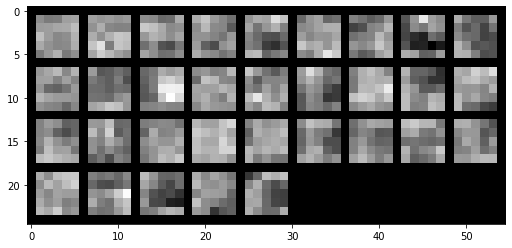

In [17]:
plot_kernels(filters_loader[2], nrow=9)

# Discriminators

In [18]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [19]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=(3, 3), padding=(1, 1), bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [20]:
RANDOM_SEED = 0
set_random_seeds(seed_value=RANDOM_SEED, device=device)

netD = Discriminator().to(device)
netD.apply(weights_init)
print('Number of weights:', np.sum([np.prod(p.shape) for p in netD.parameters()]))

Number of weights: 75840


In [21]:
netD

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

In [22]:
netD(torch.ones((1, 1, 7, 7))).shape

torch.Size([1, 1, 7, 7])